##  Data Collection & Preparation
### Task 2 - Data Preparation and Analysis:

*API used- **The Movie Db (TMDb)** <br/>
API Link - https://developers.themoviedb.org/3*

In this assignment I will perform data cleaning and data transformation on the movie data which was collected in the previous task and then I will perform data analysis on that dataset.

This notebook covers Task 2 - Data Preparation and Analysis. Since the raw data is in JSON format so I will convert it into a more appropriate dataframe form and then I will perform cleaning and analysis procedures.

In [785]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
import ast
%matplotlib inline

## Data Preparation

### Data Preprocessing:

Function to load the JSON files (raw data) from the previous task and then parse it into the pandas dataframe

In [786]:
def parse_frame(path, choice, seasons = 0):
    # Loading JSON
    fin = open(path, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    fin.close()
    
    if choice == 1:
        # returning the movie dataframe
        df_movie = pd.DataFrame(data.values())
        print("Successfully generated the movie details dataframe")
        return df_movie
    
    elif choice == 2:
        #Creating dataframe for tv show
        df1 = pd.DataFrame(data["season-1"]['episodes'])
        df_tv = pd.DataFrame(columns=df1.columns)

        # Merging the data for all the seasons into one dataframe
        for i in range(1, seasons+1):
            name = "season-"+str(i)
            df1 = pd.DataFrame(data[name]['episodes'])
            df_tv = df_tv.append(df1)
        print("Successfully generated the tv show details dataframe")
        return df_tv
    
    elif choice == 3:
        # Creating dataframe for cast and crew
        df_crew = pd.DataFrame(data["show_cast"]['crew'])
        df_cast = pd.DataFrame(data["show_cast"]['cast'])
        print("Successfully generated the cast and crew details dataframe")
        return df_cast, df_crew
    
    elif choice == 4:
        # Creating dataframe for similar show
        df_similar_show = pd.DataFrame(data["similar_show"]['results'])
        print("Successfully generated the similar tv show dataframe")
        return df_similar_show
    
    else:
        raise Exception("Invalid Choice Parameter")

Calling the parse_frame function and creating the dataframes for movie and tv show data

In [867]:
df_movie = parse_frame("raw/movie_data.json",1)
df_show = parse_frame("raw/show_data.json",2, 8)
df_cast, df_crew = parse_frame("raw/show_data.json",3)
df_similar_show = parse_frame("raw/show_data.json",4)

Successfully generated the movie details dataframe
Successfully generated the tv show details dataframe
Successfully generated the cast and crew details dataframe
Successfully generated the similar tv show dataframe


Now, I have successfully pre processed the json data into more usable dataframe format. These frames will be fed into the data cleaning step to keep the interesting and cleaned columns.

### Data Verification

Let's explore the movie dataframe first. In the below steps, we will explore the dataframe shape, data types and some descriptive statistics to find the columns with the most useful information.

In [788]:
df_movie.shape

(12400, 25)

Currently, there are around 12.5k movie details with it's 25 attributes.

In [789]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  12400 non-null  bool   
 1   backdrop_path          11796 non-null  object 
 2   belongs_to_collection  2921 non-null   object 
 3   budget                 12400 non-null  int64  
 4   genres                 12400 non-null  object 
 5   homepage               12386 non-null  object 
 6   id                     12400 non-null  int64  
 7   imdb_id                12264 non-null  object 
 8   original_language      12400 non-null  object 
 9   original_title         12400 non-null  object 
 10  overview               12400 non-null  object 
 11  popularity             12400 non-null  float64
 12  poster_path            12364 non-null  object 
 13  production_companies   12400 non-null  object 
 14  production_countries   12400 non-null  object 
 15  re

Descriptive Statistics of the uncleaned dataframe

In [790]:
df_movie.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,1.240000e+04,12400.000000,12400.000000,1.240000e+04,12397.000000,12400.000000,12400.000000
mean,1.625388e+07,178768.562097,33.330680,4.442979e+07,99.156167,6.164750,1028.049274
std,3.408560e+07,240033.755200,153.513666,1.345768e+08,27.492731,1.340736,2331.287353
min,0.000000e+00,5.000000,3.424000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,13440.750000,10.436750,0.000000e+00,90.000000,5.700000,65.000000
50%,0.000000e+00,45285.500000,15.833000,0.000000e+00,99.000000,6.300000,215.000000
75%,1.800000e+07,304119.750000,27.434250,2.436928e+07,111.000000,7.000000,863.000000
max,3.800000e+08,948801.000000,10728.703000,2.847246e+09,432.000000,10.000000,31149.000000


There seems to be two title columns. Let's check what do they signify and which one is more useful.

In [791]:
# Checking the observations where original title do not match with title column
df_movie[['original_title', 'title']].query('original_title != title')

,original_title,title
16,Amores perros,Amores Perros
20,Hable con ella,Talk to Her
31,英雄,Hero
35,Elementarteilchen,The Elementary Particles
38,Todo sobre mi madre,All About My Mother
...,...,...
12380,Sen Yasamaya Bak,In Good Hands
12383,1918: La gripe española,1918: The Spanish Flu
12387,屠魔战神,Fighting Darksider
12390,玛纳斯人之失落的秘境,The Secret of Immortal


It seems like "original title" is more initial raw form of the actual movie title. The "Title" column seems to be more appropriate for analysis purposes.

Exploring instances where the Runtime is 0 since those instance doesn't make much sense.

In [792]:
# Checking the instances where runtime of the movie is 0
df_movie[['title','runtime','status','budget','revenue']].query('runtime == 0')

,title,runtime,status,budget,revenue
4172,Aladdin: A Musical Spectacular,0.0,Released,0,0
5490,Amateur Porn Star Killer 2,0.0,Released,0,0
6018,Palermo-Milano Solo Andata,0.0,Released,0,0
6021,A spasso nel tempo - L'avventura continua,0.0,Released,0,0
6559,La vengeance d'une blonde,0.0,Released,0,0
...,...,...,...,...,...
12392,Honecker und der Pastor,0.0,Released,0,0
12393,Seventeen Power Of Love: The Movie,0.0,Released,0,0
12395,L'Heure du départ,0.0,Released,0,0
12397,UFC Fight Night 204: Volkov vs. Aspinall,0.0,Released,0,0


The above titles seems to have budget and revenue as 0 so we will have to get rid of these observations since these instances would not provide any new insights.

In [793]:
# Confirming if the only status is "Released"
df_movie.status.unique()

array(['Released', 'Post Production', 'In Production', 'Planned',
       'Canceled'], dtype=object)

### Data Cleaning and Data Transformation

This step involves cleaning, filtering and the transformation of the different datasets into more usable formats.

#### Function to clean and transform the movie data in accordance with the observed instances.

In [806]:
def movie_data_transformation(df_movie):
    df = df_movie.copy()
    df['production_companies'] = df['production_companies'].apply(lambda x: "|".join([item['name'] for item in x]))
    df['production_countries'] = df['production_countries'].apply(lambda x: "|".join([item['name'] for item in x]))
    df['genres'] = df['genres'].apply(lambda x: "|".join([item['name'] for item in x]))
    df['spoken_languages'] = df['spoken_languages'].apply(lambda x: "|".join([item['english_name'] for item in x]))
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: x['name'] if x is not None else x)
    
    # Drop the irrelevant rows
    index_err = df.query('runtime == 0 or budget == 0 or revenue == 0').index
    df.drop(index_err, axis=0, inplace=True)
    
    # changing the datatype for columns
    change_type=['budget', 'revenue']
    df[change_type]=df[change_type].applymap(np.int64)
    df.release_date=pd.to_datetime(df['release_date'])
    
    # Ungrouping the date column into year, month and day
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.strftime('%b')
    df['release_day'] = df['release_date'].dt.day_name()
    
    # creating a profit column from the already existing columns 
    df['profit'] = df['revenue'] - df['budget']
    
    # Drop the irrelevant columns
    drop_columns = ['id', 'imdb_id', 'release_date', 'backdrop_path', 'original_title', 'overview', 'poster_path', 'video', 'homepage', 'original_language', 'vote_count', 'adult', 'tagline', 'spoken_languages']
    df.drop(drop_columns, axis=1, inplace=True)
    
    # Rearranging the attributes
    df = df[['title','release_year','release_month','release_day','runtime','belongs_to_collection','genres','status','budget','revenue','profit','popularity','vote_average','production_companies','production_countries']]
    
    return df

Calling the movie_data_transformation function to clean and transform the movie details dataframe

In [807]:
df_movie_transformed = movie_data_transformation(df_movie)

Now, let's explore the transformed dataset

In [808]:
df_movie_transformed.head(5)

,title,release_year,release_month,release_day,runtime,belongs_to_collection,genres,status,budget,revenue,profit,popularity,vote_average,production_companies,production_countries
0,Four Rooms,1995,Dec,Saturday,98.0,None,Crime|Comedy,Released,4000000,4257354,257354,12.382,5.7,Miramax|A Band Apart,United States of America
1,Judgment Night,1993,Oct,Friday,110.0,None,Action|Thriller|Crime,Released,21000000,12136938,-8863062,9.929,6.5,Universal Pictures|Largo Entertainment|JVC,Japan|United States of America
2,Finding Nemo,2003,May,Friday,100.0,Finding Nemo Collection,Animation|Family,Released,94000000,940335536,846335536,110.658,7.8,Pixar,United States of America
3,Forrest Gump,1994,Jul,Wednesday,142.0,None,Comedy|Drama|Romance,Released,55000000,677387716,622387716,64.184,8.5,Paramount|The Steve Tisch Company,United States of America
4,American Beauty,1999,Sep,Wednesday,122.0,None,Drama,Released,15000000,356296601,341296601,27.340,8.0,Jinks/Cohen Company|DreamWorks Pictures,United States of America


In [809]:
# Confirming if the only status is "Released" in the transformed dataset
df_movie_transformed.status.unique()

array(['Released'], dtype=object)

Dropping the "Status" column since it contains the uniform values

In [810]:
df_movie_transformed.drop('status', axis=1, inplace=True)

In [811]:
df_movie_transformed.shape

(4668, 14)

The dataset has been transformed into 4.5k instances from 12.5k instances and attributes have also been reduced to 18

In [812]:
df_movie_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4668 entries, 0 to 12366
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  4668 non-null   object 
 1   release_year           4668 non-null   int64  
 2   release_month          4668 non-null   object 
 3   release_day            4668 non-null   object 
 4   runtime                4668 non-null   float64
 5   belongs_to_collection  1205 non-null   object 
 6   genres                 4668 non-null   object 
 7   budget                 4668 non-null   int64  
 8   revenue                4668 non-null   int64  
 9   profit                 4668 non-null   int64  
 10  popularity             4668 non-null   float64
 11  vote_average           4668 non-null   float64
 12  production_companies   4668 non-null   object 
 13  production_countries   4668 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 547.0+

#### Descriptive Statistics of the transformed movie dataframe

In [813]:
df_movie_transformed.describe()

,release_year,runtime,budget,revenue,profit,popularity,vote_average
count,4668.000000,4668.000000,4.668000e+03,4.668000e+03,4.668000e+03,4668.000000,4668.000000
mean,2006.872751,109.231362,4.006502e+07,1.146257e+08,7.456070e+07,41.179989,6.442266
std,7.806125,19.420864,4.505969e+07,1.998597e+08,1.697989e+08,166.405279,0.825589
min,1992.000000,4.000000,1.000000e+00,1.000000e+00,-1.598219e+08,3.821000,0.000000
25%,2001.000000,95.750000,1.000000e+07,1.219985e+07,-2.446000e+06,13.389500,5.900000
50%,2007.000000,105.000000,2.500000e+07,4.416417e+07,1.757680e+07,20.287000,6.400000
75%,2013.000000,120.000000,5.000000e+07,1.280557e+08,8.004113e+07,36.769750,7.000000
max,2022.000000,271.000000,3.800000e+08,2.847246e+09,2.610246e+09,9196.371000,8.700000


Checking if any attribute contains null values

In [814]:
df_movie_transformed.isnull().sum()

title                       0
release_year                0
release_month               0
release_day                 0
runtime                     0
belongs_to_collection    3463
genres                      0
budget                      0
revenue                     0
profit                      0
popularity                  0
vote_average                0
production_companies        0
production_countries        0
dtype: int64

In [815]:
df_movie_transformed.columns[df_movie_transformed.isna().any()].tolist()

['belongs_to_collection']

Transforming the null values in the "belongs to collection" column to "No Record"

In [816]:
df_movie_transformed = df_movie_transformed.replace(np.NAN,"No Record")

Checking if the data contains any duplicate rows

In [817]:
df_movie_transformed.duplicated().sum()

0

Now, we have the cleaned movie dataframe which can be used for further exploratory data analysis

#### Function to clean and transform the tv show data.

In [818]:
def show_data_transformation(df_show):
    sdf = df_show.copy()

    # changing the datatype for columns
    change_type=['episode_number', 'season_number', 'production_code']
    sdf[change_type]=sdf[change_type].applymap(np.int64)
    sdf.air_date=pd.to_datetime(sdf['air_date'])
    
    # Ungrouping the date column into year, month and day
    sdf['air_year'] = sdf['air_date'].dt.year
    sdf['air_month'] = sdf['air_date'].dt.strftime('%b')
    sdf['air_day'] = sdf['air_date'].dt.day_name()
    
    sdf = sdf.sort_values(['season_number', 'episode_number'], ascending = [True, True])
    sdf.insert(0, 'episode_id', range(1, 1 + len(sdf)))

    # Drop the irrelevant columns
    drop_columns = ['id', 'still_path', 'overview','vote_count','production_code']
    sdf.drop(drop_columns, axis=1, inplace=True)
    
    sdf = sdf.reset_index(drop = True)
    
    # Rearranging the attributes
    sdf = sdf[['season_number','episode_id','episode_number','name','air_year','air_month','air_day','crew','guest_stars','vote_average']]
    
    return sdf

In [868]:
df_show_transformed = show_data_transformation(df_show)

Performing basic data verification steps for tv show dataset after cleaning and transformation

In [869]:
df_show_transformed.head(15)

,season_number,episode_id,episode_number,name,air_year,air_month,air_day,crew,guest_stars,vote_average
0,1,1,1,Winter Is Coming,2011,Apr,Sunday,"[{'adult': False, 'credit_id': '5256c8a219c295...","[{'adult': False, 'character': 'Will', 'credit...",7.8
1,1,2,2,The Kingsroad,2011,Apr,Sunday,"[{'adult': False, 'credit_id': '5256c8a219c295...","[{'adult': False, 'character': 'Jhiqui', 'cred...",7.6
2,1,3,3,Lord Snow,2011,May,Sunday,"[{'adult': False, 'credit_id': '5256c8a219c295...","[{'adult': False, 'character': 'Drunk Patron',...",7.9
3,1,4,4,"Cripples, Bastards, and Broken Things",2011,May,Sunday,"[{'adult': False, 'credit_id': '5256c8a219c295...","[{'adult': False, 'character': 'Samwell Tarly'...",8.0
4,1,5,5,The Wolf and the Lion,2011,May,Sunday,"[{'adult': False, 'credit_id': '5256c8a219c295...","[{'adult': False, 'character': 'Bronn', 'credi...",8.4
5,1,6,6,A Golden Crown,2011,May,Sunday,"[{'adult': False, 'credit_id': '5256c8a519c295...","[{'adult': False, 'character': 'Bronn', 'credi...",8.3
6,1,7,7,You Win or You Die,2011,May,Sunday,"[{'adult': False, 'credit_id': '5256c8a519c295...","[{'adult': False, 'character': 'Samwell Tarly'...",8.4
7,1,8,8,The Pointy End,2011,Jun,Sunday,"[{'adult': False, 'credit_id': '5256c8a519c295...","[{'adult': False, 'character': 'Samwell Tarly'...",8.1
8,1,9,9,Baelor,2011,Jun,Sunday,"[{'adult': False, 'credit_id': '54eef242925141...","[{'adult': False, 'character': 'Samwell Tarly'...",8.8
9,1,10,10,Fire and Blood,2011,Jun,Sunday,"[{'adult': False, 'credit_id': '54eef242925141...","[{'adult': False, 'character': 'Samwell Tarly'...",8.6


In [870]:
df_show_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season_number   73 non-null     int64  
 1   episode_id      73 non-null     int64  
 2   episode_number  73 non-null     int64  
 3   name            73 non-null     object 
 4   air_year        73 non-null     int64  
 5   air_month       73 non-null     object 
 6   air_day         73 non-null     object 
 7   crew            73 non-null     object 
 8   guest_stars     73 non-null     object 
 9   vote_average    73 non-null     float64
dtypes: float64(1), int64(4), object(5)
memory usage: 5.8+ KB


In [871]:
df_show_transformed.shape

(73, 10)

In [872]:
df_show_transformed.isnull().sum()

season_number     0
episode_id        0
episode_number    0
name              0
air_year          0
air_month         0
air_day           0
crew              0
guest_stars       0
vote_average      0
dtype: int64

#### Data transformation and cleaning of cast, crew and similar show dataframes

In [824]:
def clean_frames():
    df_c = df_cast.copy()
    df_cr = df_crew.copy()
    df_ss = df_similar_show.copy()
    
    drop_columns = ['adult','credit_id','id', 'profile_path', 'order','original_name']
    df_c.drop(drop_columns, axis=1, inplace=True)
    
    drop_columns = ['adult','credit_id','id', 'profile_path','job','original_name']
    df_cr.drop(drop_columns, axis=1, inplace=True)
    
    drop_columns = ['adult','id','backdrop_path', 'overview','vote_count','origin_country','original_language','original_name','poster_path']
    df_ss.drop(drop_columns, axis=1, inplace=True)
    
    return df_c, df_cr, df_ss

In [873]:
df_cast_transformed, df_crew_transformed, df_similar_transformed = clean_frames()

In [874]:
df_cast_transformed.head(1)

,character,gender,known_for_department,name,popularity
0,Tyrion Lannister,2,Acting,Peter Dinklage,12.603


In [875]:
df_crew_transformed.head(1)

,department,gender,known_for_department,name,popularity
0,Production,2,Production,Duncan Muggoch,0.6


In [876]:
df_similar_transformed.head(1)

,first_air_date,genre_ids,name,popularity,vote_average
0,2002-04-08,"[80, 18]",The Inspector Lynley Mysteries,20.046,7.6


After cleaning and transforming the movie dataframe and the tv show dataframes, we can move to data exploration and analysis step to derive insights from the data.

## Data Exploration and Analysis

This step involves data characterisation, data summarisation and analysis of the data using the tables and visualisations. Interpretation and explanation of results will be included after each analysis.

#### Part 1 - Movie Dataset Analysis

In this part of the notebook, I will analyse the movie dataset sparring over 30 years to derive any useful insights.

Let's explore the growth of movies over the period of 30 years first.

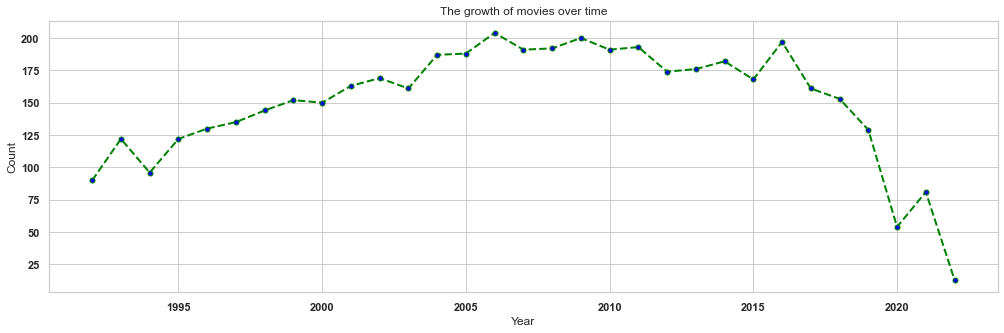

In [838]:
count_per_year = df_movie_transformed.groupby(df_movie_transformed['release_year'])['title'].count()

plt.plot(count_per_year, color='green', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5)

plt.title('The growth of movies over time')
plt.xlabel('Year')
plt.ylabel('Count')

plt.show()

The graph shows an increasing growth till 2017 and then it drops. The reason can be non uniform sample distribution over the recent years in the dataset. For the years ranging 2020-2022, covid can also be a reason when the theatrical releases were affected and there was a rise in the OTT platform releases. 

Let's explore the distribution of movies in accordance with the different attributes. These distributions will help in unfolding certain properties which can be further explored.

array([[<AxesSubplot:title={'center':'release_year'}>,
        <AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'budget'}>],
       [<AxesSubplot:title={'center':'revenue'}>,
        <AxesSubplot:title={'center':'profit'}>,
        <AxesSubplot:title={'center':'popularity'}>],
       [<AxesSubplot:title={'center':'vote_average'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

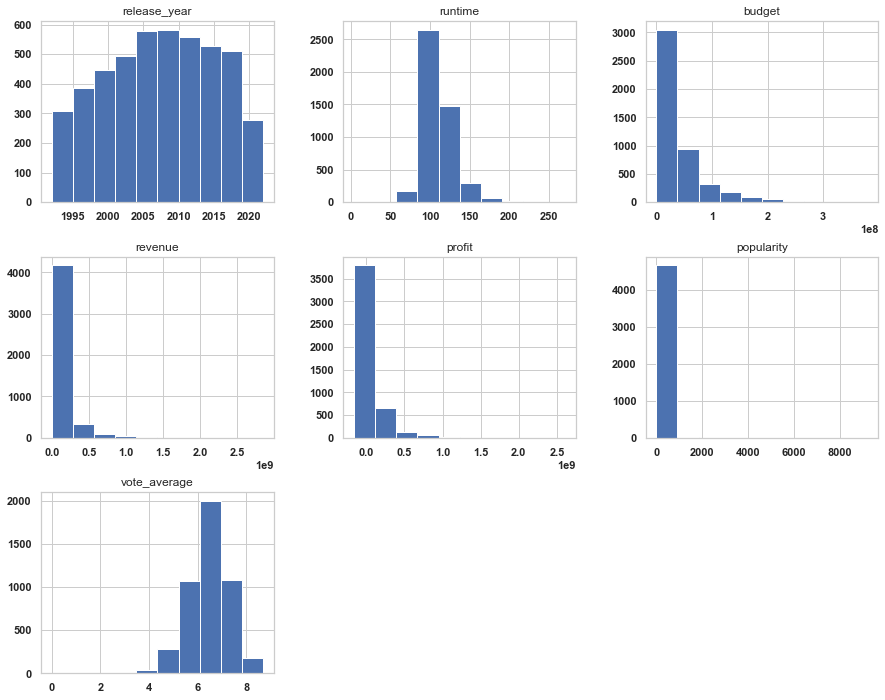

In [830]:
df_movie_transformed.hist(figsize = (15,12))

It can be observed from the above histograms that:
- 2006-2017 were the years where most movies titles were released within the dataset.
- Average runtime appears to be 1.5-1.75 hours.
- Very few movie titles appears to have high budget, revenue and profit.
- Average vote seems to be within the range [5,8].
- The vote_average is left skewed, it is asymmetric with a tail on the left, with the mean value is around 6.

Creating a function to find the minima and maxima on the basis of the user specified attribute.

In [831]:
def find_highlow(x):
    # finding the index of lowest value movie.
    min_index = df_movie_transformed[x].idxmin()
    
    # finding the index of highest value movie.
    max_index = df_movie_transformed[x].idxmax()
    
    high = pd.DataFrame(df_movie_transformed.loc[max_index,:])
    low = pd.DataFrame(df_movie_transformed.loc[min_index,:])
    
    high.columns = high.iloc[0]
    low.columns = low.iloc[0]
    
    high.drop('title', axis=0, inplace=True)
    low.drop('title', axis=0, inplace=True)
    
    # print the movie with min and max index
    print("Movie which has Highest "+ x + " : ",df_movie_transformed['title'][max_index])
    print("Movie which has Lowest "+ x + "  : ",df_movie_transformed['title'][min_index])
    
    # returning the concatenated frame for min and max indexes
    return pd.concat([high,low],axis = 1)

#### What are the movies with the highest and lowest profits?

In [832]:
#calling the find_highlow function.
fhl_profit = find_highlow('profit')
fhl_profit

Movie which has Highest profit :  Avatar
Movie which has Lowest profit  :  Red Notice


title,Avatar,Red Notice
release_year,2009,2021
release_month,Dec,Nov
release_day,Thursday,Thursday
runtime,162.0,118.0
belongs_to_collection,Avatar Collection,Red Notice Collection
genres,Action|Adventure|Fantasy|Science Fiction,Action|Comedy|Crime|Thriller
budget,237000000,160000000
revenue,2847246203,178143
profit,2610246203,-159821857
popularity,297.352,1550.235


#### What are the movies with the highest and lowest runtimes?

In [833]:
#calling the find_highlow function.
fhl_runtime = find_highlow('runtime')
fhl_runtime

Movie which has Highest runtime :  Gettysburg
Movie which has Lowest runtime  :  Lonely


title,Gettysburg,Lonely
release_year,1993,2022
release_month,Oct,Mar
release_day,Friday,Friday
runtime,271.0,4.0
belongs_to_collection,American Civil War Collection,No Record
genres,Drama|History|War,Drama|Romance
budget,25000000,774
revenue,12700000,20
profit,-12300000,-754
popularity,12.64,22.008


#### Range of runtimes available

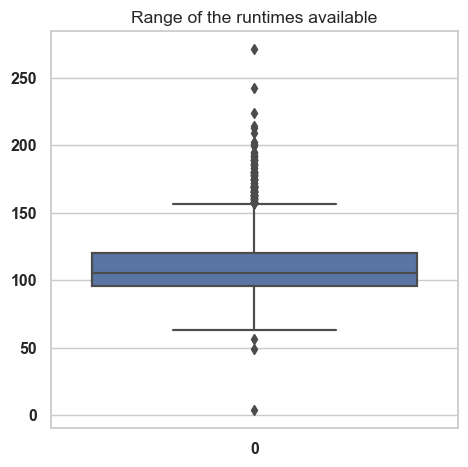

In [834]:
plt.figure(figsize=(5,5), dpi = 105)
plt.title('Range of the runtimes available')
sns.boxplot(data = df_movie_transformed['runtime'])
plt.show()

- 25% of the movie titles have a runtime of less than 100 minutes 
- 50% of the movie titles have a runtime of less than 105 minutes. 
- 75% of the movie titles have a runtime of less than 120 minutes.

#### Does the length of the movie affect its revenue?

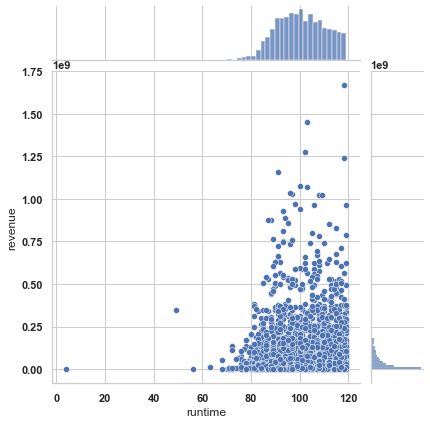

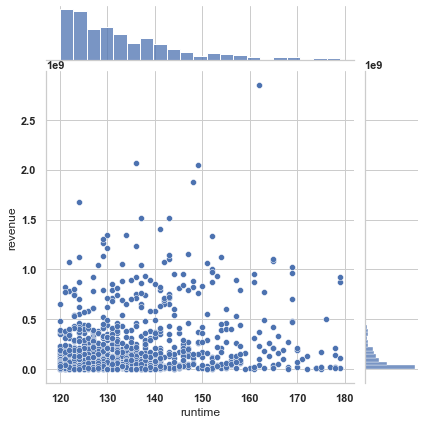

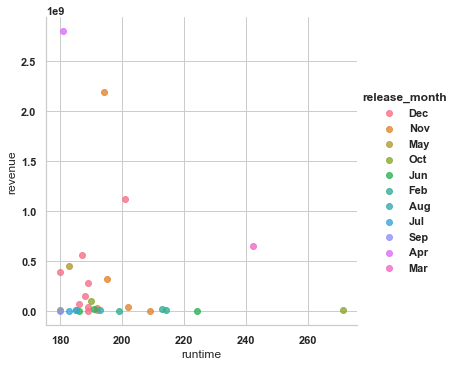

In [835]:
# Dividing the runtime into 3 bins 
time_low = df_movie_transformed.query('runtime < 120')
time_mid = df_movie_transformed.query('runtime >= 120 & runtime < 180')
time_high = df_movie_transformed.query('runtime >= 180')

# Creating a jointplot to show correlation
sns.jointplot(x='runtime', y='revenue', data=time_low)
sns.jointplot(x='runtime', y='revenue', data=time_mid)
sns.lmplot(x='runtime', y='revenue', data=time_high,
           fit_reg=False, 
           hue='release_month')

There is strong positive correlation amongst runtime and revenue attributes in the cases of low to mid runtime range but very weak correlation for the high runtime range.

#### How the runtime of the movies differ year to year.

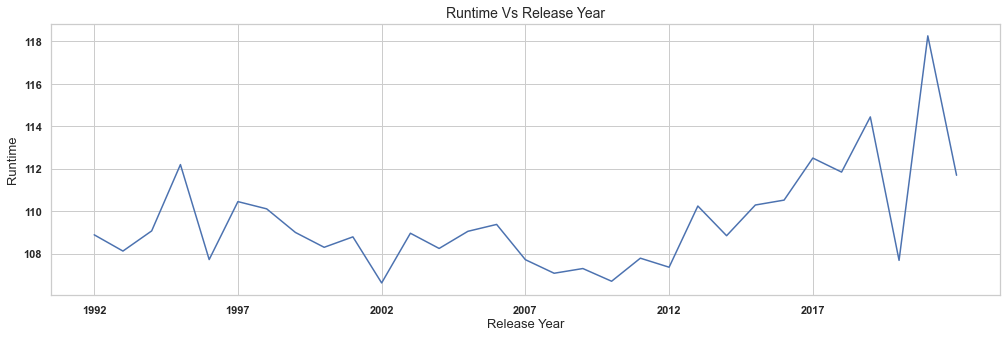

In [837]:
df_movie_transformed.groupby('release_year').mean()['runtime'].plot(xticks = np.arange(1992,2022,5))

sns.set(rc={'figure.figsize':(17,5)})
plt.title("Runtime Vs Release Year",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('Runtime',fontsize = 13)
sns.set_style("whitegrid")

Till 2015, the runtimes were ranging between 100-120 minutes but in the recent years there was a sudden increase in the runtime by 20-30 minutes

Now, let's see how runtime affects popularity

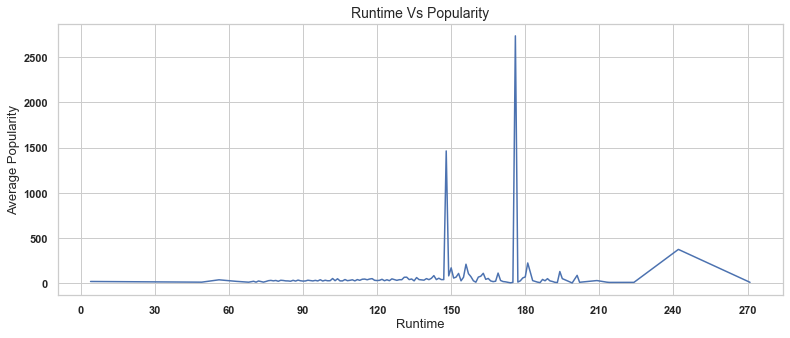

In [839]:
df_movie_transformed.groupby('runtime')['popularity'].mean().plot(figsize = (13,5),xticks=np.arange(0,300,30))

plt.title("Runtime Vs Popularity",fontsize = 14)
plt.xlabel('Runtime',fontsize = 13)
plt.ylabel('Average Popularity',fontsize = 13)
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

It's clearly evident that certain runtimes such as 140 minutes and 160 minutes for the movie titles have sudden peaks in popularity.

#### Movie Collections Vs Revenue

In [840]:
# Creating a dataframe by pivoting on the collection attribute and generating the aggregates for the revenue attribute
collection_pivot = df_movie_transformed.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['sum', 'count']}).reset_index()
collection_pivot = collection_pivot[collection_pivot.belongs_to_collection != 'No Record']

##### - Most Successful Franchises

In [841]:
collection_pivot.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,sum
519,The Avengers Collection,4,7768259410
236,Harry Potter Collection,8,7706878644
482,Star Wars Collection,6,6898782588
546,The Fast and the Furious Collection,9,5854976167
282,James Bond Collection,9,5431032175
396,Pirates of the Caribbean Collection,5,4522246632
642,Transformers Collection,5,4379232709
298,Jurassic Park Collection,3,3895272793
471,Spider-Man (Avengers) Collection,3,3888780874
352,Mission: Impossible Collection,6,3570030286


The above table shows the top 10 most successful franchises. **"The Avengers Collection"** is the most successful franchise in terms of the highest revenue they have generated.

##### - Longest Running Franchises

In [842]:
collection_pivot.sort_values('count', ascending=False).head(10)

,belongs_to_collection,count,sum
546,The Fast and the Furious Collection,9,5854976167
282,James Bond Collection,9,5431032175
236,Harry Potter Collection,8,7706878644
437,Saw Collection,8,981261940
388,Paranormal Activity Collection,6,886011827
482,Star Wars Collection,6,6898782588
352,Mission: Impossible Collection,6,3570030286
601,The Purge Collection,5,533895379
396,Pirates of the Caribbean Collection,5,4522246632
327,Madea Collection,5,300505675


The above table shows the top 10 longest running franchises. **"The Fast and the Furious Collection" and the "James Bond Collection"** are the longest running franchises in terms of the most frequent titles released.

<AxesSubplot:ylabel='belongs_to_collection'>

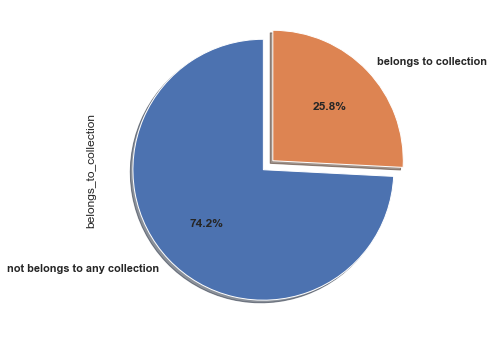

In [843]:
df_collect = pd.DataFrame()
df_collect['belongs_to_collection'] = df_movie_transformed['belongs_to_collection'].apply(lambda x: 0 if x == "No Record" else 1)
df_collect['belongs_to_collection'].value_counts().plot(kind='pie',labels=['not belongs to any collection','belongs to collection'],startangle=90,shadow=True,
            figsize=(6,6),autopct="%1.1f%%", explode=(0,0.1))

The above pie chart shows that there are only 25% of the movie titles which belongs to certain franchise and the rest are individual titles.

#### Top Movies on the basis of their budget

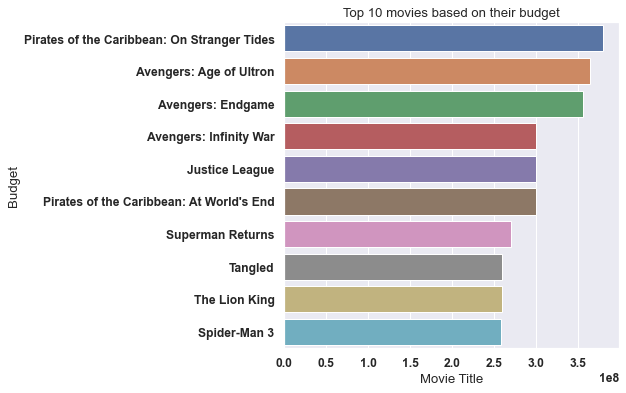

In [844]:
sns.set(rc={'figure.figsize':(6,6)}, font_scale=1.1)

ax = sns.barplot(
    x = df_movie_transformed.sort_values(by="budget", ascending=False).head(10).budget,
    y = df_movie_transformed.sort_values(by="budget", ascending=False).head(10).title, 
    orient = 'h')

ax.set(xlabel='Movie Title', ylabel='Budget', title = 'Top 10 movies based on their budget')
plt.show()

#### Top Movies based on their revenue

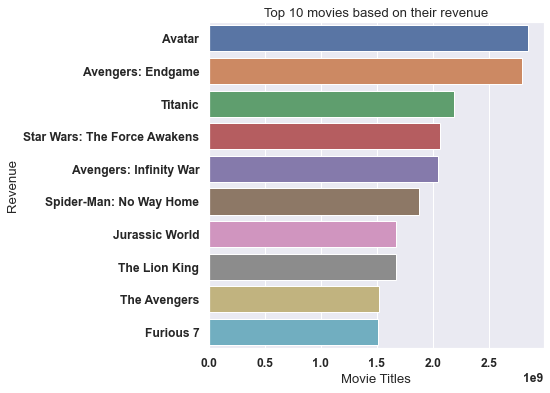

In [845]:
sns.set(rc={'figure.figsize':(6,6)}, font_scale=1.1)


ax = sns.barplot(
    x = df_movie_transformed.sort_values(by = "revenue", ascending=False).head(10).revenue,
    y = df_movie_transformed.sort_values(by = "revenue", ascending=False).head(10).title, 
    orient = 'h')

ax.set(xlabel='Movie Titles', ylabel='Revenue', title = 'Top 10 movies based on their revenue')
plt.show()

#### Movie Rating Distribution per Year

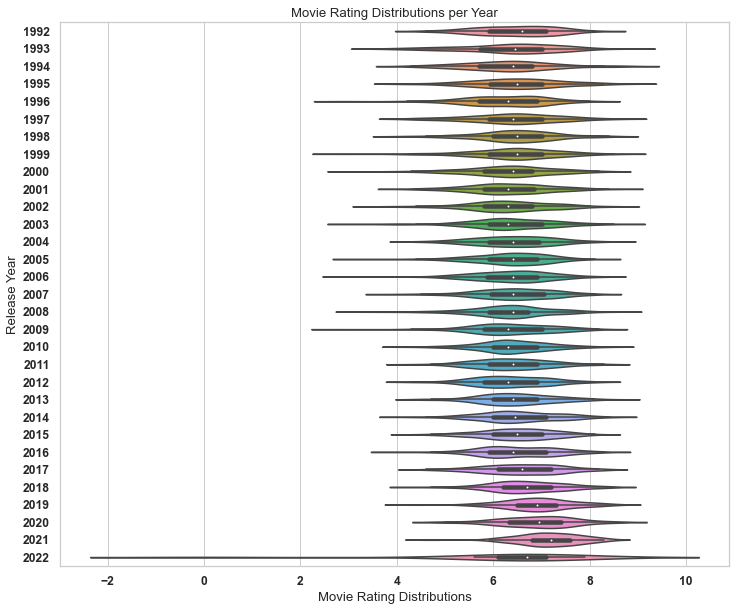

In [846]:
sns.set(rc={'figure.figsize':(12,10)}, font_scale=1.1)
sns.set_style("whitegrid")

ax = sns.violinplot(x = df_movie_transformed.vote_average, y = df_movie_transformed.release_year, orient ="h")

ax.set(xlabel='Movie Rating Distributions', ylabel='Release Year', title = 'Movie Rating Distributions per Year')
plt.show()

Generated a violin plot to show the movie rating (vote_average) distribution over the period of 30 years. It shows that the most of the ratings lie between 5-9.

Creating a function to transform the columns with pipe separator into value separated counts

In [847]:
def transform_pipes(column):
    data = df_movie_transformed[column].str.cat(sep = '|')
    data = pd.Series(data.split('|'))
    count = data.value_counts(ascending = False)
    return count

Text(0.5, 1.0, 'Best Genres')

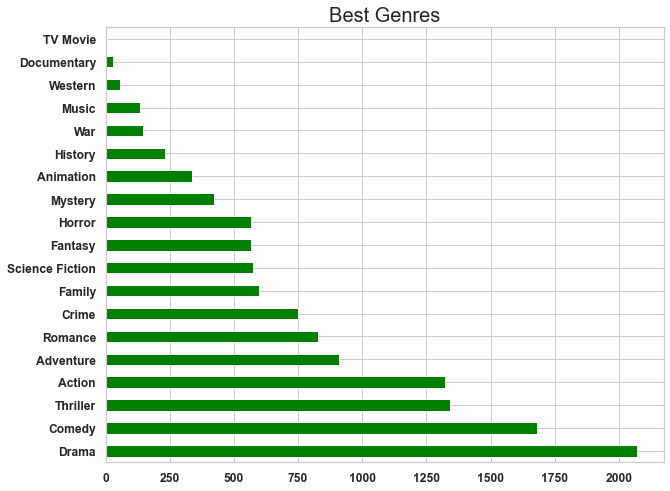

In [848]:
genre_cdf = transform_pipes('genres')

# Plotting horizontal bar graph
gph = genre_cdf.plot(kind="barh",color="green")
gph.figure.set_size_inches(10, 8)

l.set_ylabel('Genres', color = 'black', fontsize = '12')
l.set_xlabel('Count', color = 'black', fontsize = '12')
plt.title("Best Genres", size=20)

Comedy and Drama are the top two genres for the movies

#### How the popularity of the genre differ year by year

Creating a function to create a mapping of genre and popularity for each release year

In [849]:
def genre_pop_mapping():
    
    # Creating a list from the genre column.
    genre_details = list(map(str,(df_movie_transformed['genres'])))
    
    #Defining to set columns
    genre_lst = ['Adventure', 'Science Fiction', 'Fantasy', 'Crime', 'Western', 'Family', 'Animation','War','Mystery','Romance','TV Movie','Action', 'Thriller','Comedy','Drama' , 'History', 'Music', 'Horror', 'Documentary', 'Foreign']

    # Array for all the release years 
    ryear = np.array(df_movie_transformed['release_year'])
    # Array for all the popularity indexes
    popularity_index = np.array(df_movie_transformed['popularity'])
    p_df = pd.DataFrame(index = genre_lst, columns = range(1992, 2023))
    p_df = p_df.fillna(value = 0.0)

    x = 0
    for i in genre_details:
        splitg = list(map(str,i.split('|')))
        p_df.loc[splitg, ryear[x]] = p_df.loc[splitg, ryear[x]] + popularity_index[x]
        x += 1
    
    return p_df

def calculate_zscore(x):
    return (x-x.mean())/x.std(ddof=0)


In [850]:
popularity_df = genre_pop_mapping()
find_pg = calculate_zscore(popularity_df)

Creating lineplot matrix for popularity per year for each genre 

<AxesSubplot:>

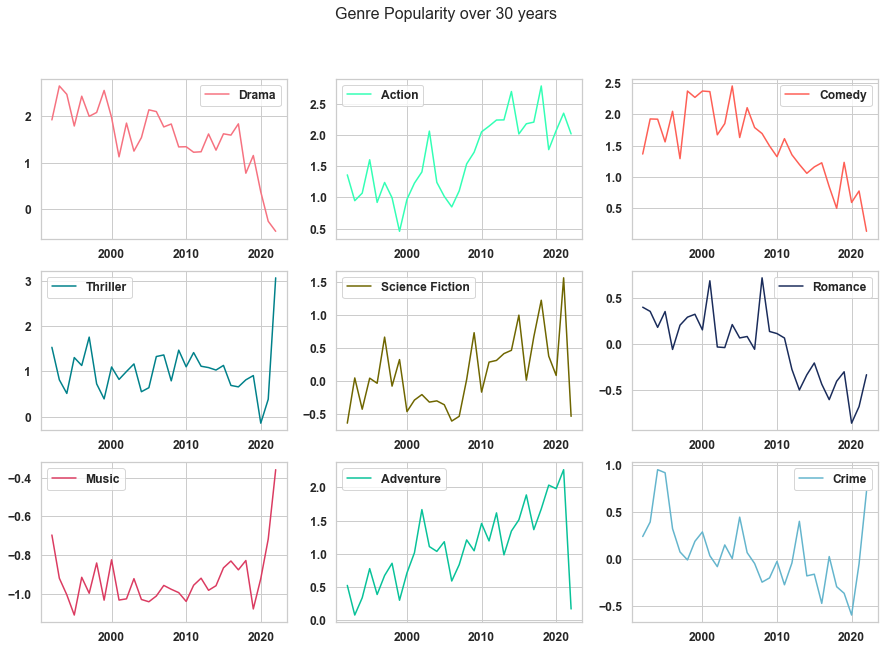

In [851]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(3,3,figsize = (15,10))
fig.suptitle('Genre Popularity over 30 years',fontsize = 16)

# Plotting each genre popularity vs years as a matrix
find_pg.loc['Drama'].plot(label = "Drama",color = '#f67280',ax = ax[0][0],legend=True)
find_pg.loc['Action'].plot(label = "Action",color='#33FFB5',ax = ax[0][1],legend=True)
find_pg.loc['Comedy'].plot(label = "Comedy",color='#fe5f55',ax = ax[0][2],legend=True)
find_pg.loc['Thriller'].plot(label = "Thriller",color='#00818a',ax = ax[1][0],legend=True)
find_pg.loc['Science Fiction'].plot(label = "Science Fiction",color='#6f6600',ax = ax[1][1],legend=True)
find_pg.loc['Romance'].plot(label = "Romance",color='#1a2c5b',ax = ax[1][2],legend=True)
find_pg.loc['Music'].plot(label = "Music",color='#db3b61',ax = ax[2][0],legend=True)
find_pg.loc['Adventure'].plot(label = "Adventure",color='#08c299',ax = ax[2][1],legend=True)
find_pg.loc['Crime'].plot(label = "Crime",color='c',ax = ax[2][2],legend=True)

The above plot shows that the "Action", "Music", "Thriller" and the "Crime" genres have gained more popularity over the years than rest of the genres.

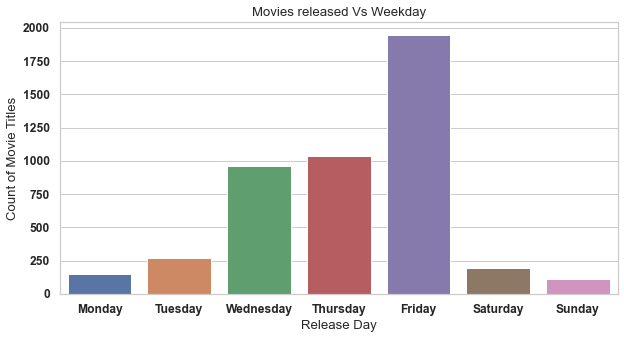

In [852]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10,5))

ax = sns.countplot(x='release_day', data = df_movie_transformed, order = day_order)
ax.set(xlabel='Release Day', ylabel='Count of Movie Titles', title = 'Movies released Vs Weekday')

plt.show()

Friday appears to be the day when maximum number of movies have released

#### Correlations

In this section, I will investigate the scatterplots and correlations between the revenue, budget, popularity, vote average and the runtime.

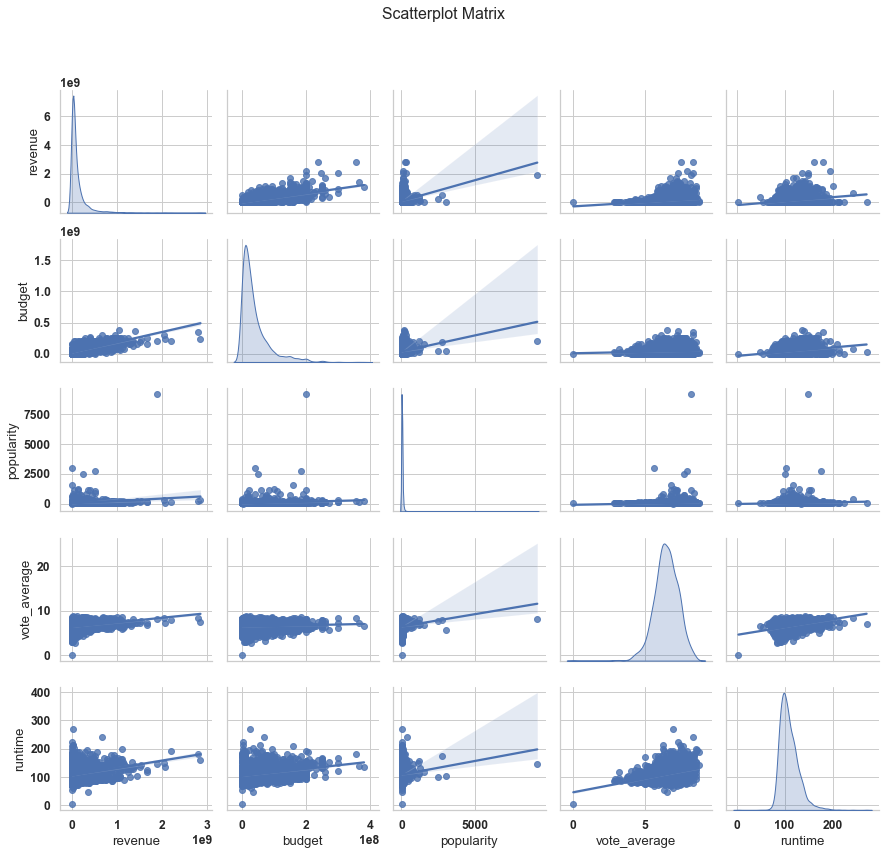

In [853]:
aux_df = df_movie_transformed[['revenue', 'budget', 'popularity', 'vote_average', 'runtime']]
f1 = sns.pairplot(aux_df, kind = "reg", diag_kind = "kde", diag_kws = dict(shade=True))
f1.fig.suptitle('Scatterplot Matrix')
f1.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Looking at the above graphs, strong positive correlation can be inferred between [budget, revenue], [runtime,vote average] and popularity indexes. Rest of the correlations seems weak in their nature such as vote average and budget/revenue.

Defining a function to generate a heatmap correlation matrix

In [854]:
def draw_matrix(df):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 10 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

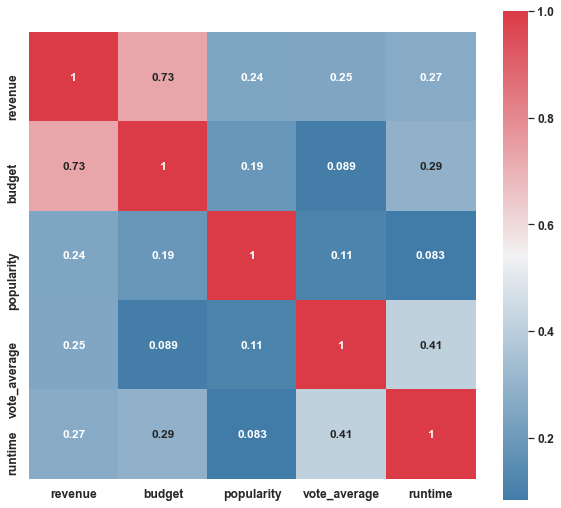

In [855]:
draw_matrix(df_movie_transformed[['revenue', 'budget', 'popularity', 'vote_average', 'runtime']])

The above plot shows the correlation matrix as a heatmap for the mentioned attributes. The conclusions seems same as above. Value greater than 0.4 is a good correlation.

#### Part 2 - TV Show Dataset Analysis (Game of Thrones)

In this part of the notebook, I will analyse the "Game of Thrones" TV Show dataset to derive some meaningful insights.

![title](img/got.jpg)

Let's start by checking the average season rating for the show.

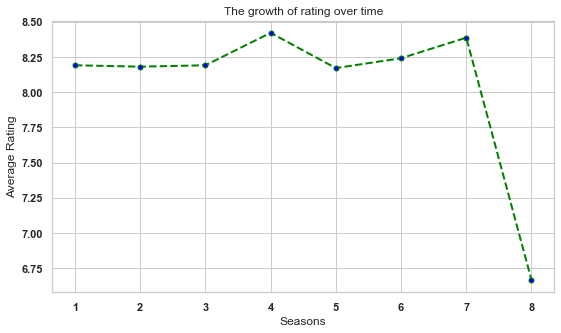

In [877]:
show_rating = df_show_transformed.groupby(df_show_transformed['season_number'])['vote_average'].mean()

plt.plot(show_rating, color='green', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='blue', markersize=5)

plt.title('The growth of rating over time')
plt.xlabel('Seasons')
plt.ylabel('Average Rating')

plt.show()

The show rating seems almost uniform for all the seasons except 4th season when the rating took a hit from 8.2 to 8.4 and the final season when the rating dipped from 8.4 to 6.5

In [878]:
def minmax_episode(x):
    # finding the index of lowest value movie.
    min_index = df_show_transformed[x].idxmin()
    
    # finding the index of highest value movie.
    max_index = df_show_transformed[x].idxmax()
    
    high = pd.DataFrame(df_show_transformed.loc[max_index,:])
    low = pd.DataFrame(df_show_transformed.loc[min_index,:])
    
    high.columns = high.iloc[3]
    low.columns = low.iloc[3]
    
    high.drop('name', axis=0, inplace=True)
    low.drop('name', axis=0, inplace=True)
    
    # print the movie with min and max index
    print("Episode which has Highest "+ x + " : ",df_show_transformed['name'][max_index])
    print("Episode which has Lowest "+ x + "  : ",df_show_transformed['name'][min_index])
    
    # returning the concatenated frame for min and max indexes
    return pd.concat([high,low],axis = 1)

In [879]:
check = minmax_episode('vote_average')

Episode which has Highest vote_average :  The Winds of Winter
Episode which has Lowest vote_average  :  The Iron Throne


In [880]:
most_liked = df_show_transformed.groupby('season_number').max(1, ['vote_average'])
most_liked[['episode_number','name','vote_average']]

,episode_number,name,vote_average
season_number,,,
1,10,You Win or You Die,8.8
2,10,What is Dead May Never Die,8.8
3,10,Walk of Punishment,9.1
4,10,Two Swords,9.0
5,10,"Unbowed, Unbent, Unbroken",9.2
6,10,The Winds of Winter,9.3
7,7,The Spoils of War,8.8
8,6,Winterfell,7.8


The above table shows the top rated episodes for each season. The highest rated episode of all seasons was "The winds of winter" and the lowest rated episode was "The Iron Throne"

#### Most episode airs in terms of weekday and month

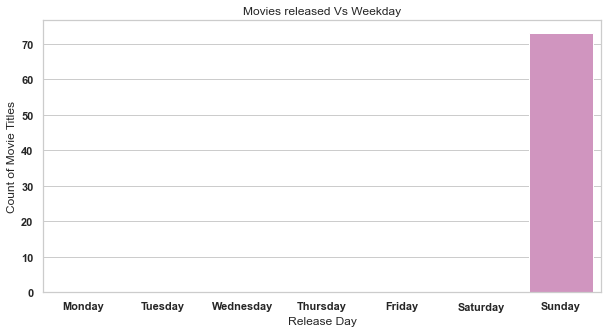

In [881]:
plt.figure(figsize=(10,5))

ax = sns.countplot(x='air_day', data = df_show_transformed, order = day_order)
ax.set(xlabel='Release Day', ylabel='Count of Movie Titles', title = 'Movies released Vs Weekday')

plt.show()

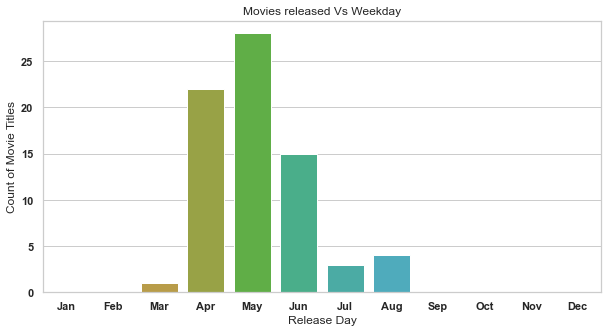

In [882]:
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=(10,5))

ax = sns.countplot(x='air_month', data = df_show_transformed, order = month_order)
ax.set(xlabel='Release Day', ylabel='Count of Movie Titles', title = 'Movies released Vs Weekday')

plt.show()

The plot shows that all of the GOT episodes were aired on Sunday and the maximum number of episodes were aired in the month of May.

#### Which department had the most human power involvement for this show?

<AxesSubplot:xlabel='department', ylabel='count'>

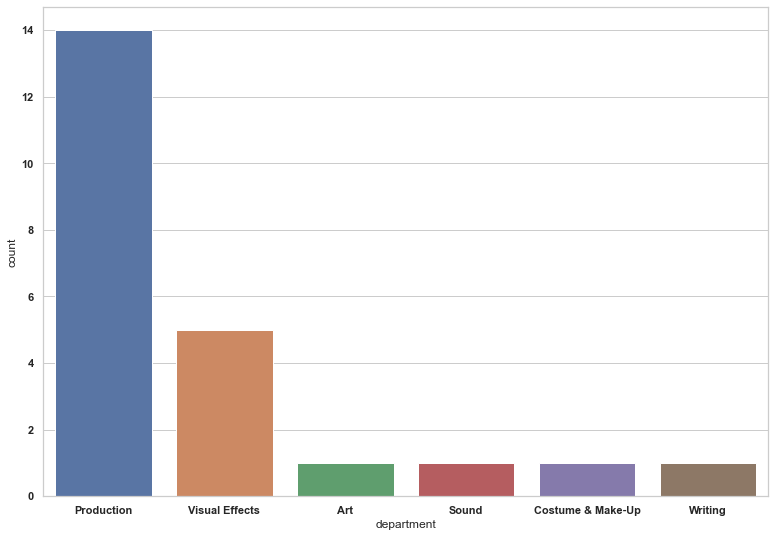

In [883]:
sns.set(rc={'figure.figsize':(13,9)})
sns.set_style('whitegrid')
sns.countplot(x='department',data=df_crew_transformed)

It seems from the bar plot that production and visual effects departments had the most number of human involvement and it definitely justifies the kind of production and cinematography was shown within the show.

#### What is gender distribution within the crew departments?

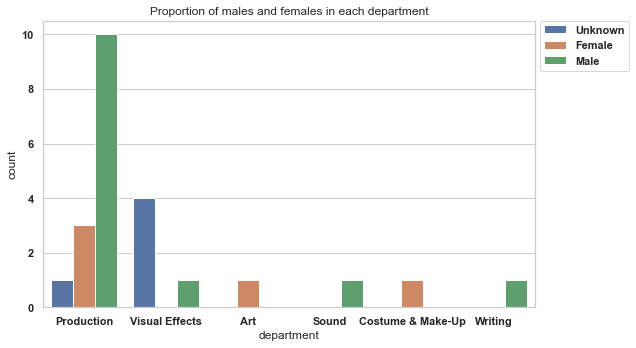

In [884]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style('whitegrid')

sns.countplot(x='department',hue='gender',data=df_crew_transformed)

plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0,labels=['Unknown','Female','Male'])
plt.title("Proportion of males and females in each department")
plt.tight_layout()

Production department had the major population as males and for the visual effects department, majority of the gender are unknown

#### Most Popular Actors of the Game of Thrones Show

Text(0, 0.5, 'Popularity Score')

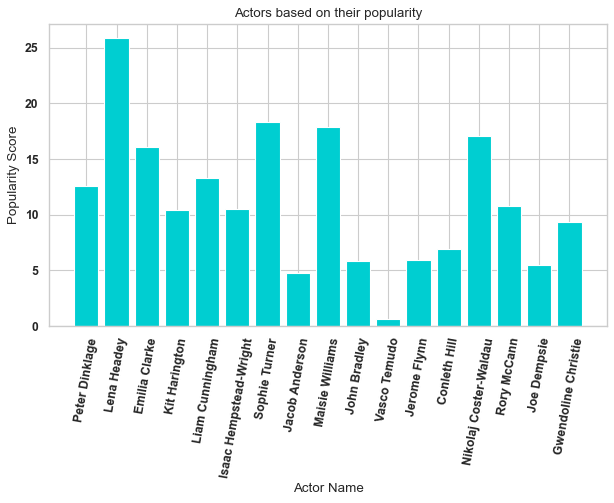

In [885]:
plt.figure(figsize=(9,5), dpi= 80)
plt.xticks(rotation = 80)
plt.bar(df_cast_transformed['name'],df_cast_transformed['popularity'],color = "#00CED1")
plt.title('Actors based on their popularity')
plt.xlabel('Actor Name')
plt.ylabel('Popularity Score')

In [886]:
popularity_sorted = df_cast_transformed.sort_values(['popularity'], ascending = [False])
popularity_sorted = popularity_sorted[['name','character','popularity']]
popularity_sorted.head(3)

,name,character,popularity
1,Lena Headey,Cersei Lannister,25.848
6,Sophie Turner,Sansa Stark,18.372
8,Maisie Williams,Arya Stark,17.908


This shows that the most popular character of the show has been Cersei Lannister, followed by Sansa Stark and Arya Stark

#### Most Popular Similar Show with respect to the Game of Thrones

Text(0, 0.5, 'Popularity Score')

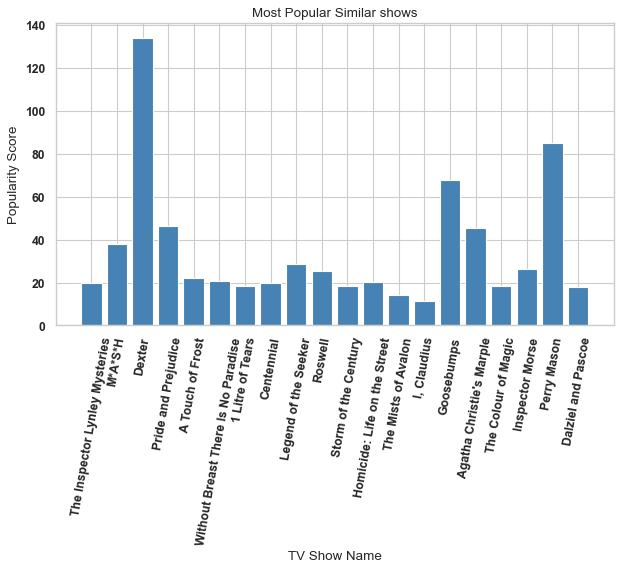

In [887]:
plt.figure(figsize=(9,5), dpi= 80)
plt.xticks(rotation = 80)
plt.bar(df_similar_transformed['name'],df_similar_transformed['popularity'],color = "#4682B4",label = 'Similar show based on popularity')
plt.title('Most Popular Similar shows')
plt.xlabel('TV Show Name')
plt.ylabel('Popularity Score')

The result shows that "The Vampire Diaries" is the most popular show in terms of the similarity with the GOT Series

## Conclusion:

### Summary of Insights:

- There is a major growth in the number of movies released from 1992 to 2017.
- "Avatar" has been the most successful movies of all time in terms of the profit that was generated.
- It was noticed using the boxplot chart that the 25% of the movies have a runtime of less than 100 minutes, 50% have less than 105 minutes and 75% have less than 120 minutes.
- The analysis derived a strong positive correlation between the runtime of the movie and the revenue of the movie for when the runtime was less than 180 minutes. So, it can be said that the length of the movie does affect the revenue of the movie.
- It was also noticed that the runtime of the movies have seen a certain growth from 1992 to 2020. From 1992 to 2012, the average runtime has been 100 minutes but it took a hit of 20 minutes in 2020.
- From the "belongs_to_collection" attribute, the most successful and longest running franchises were derived. The most successful collection has been "The Avengers Collection" and "The Harry Potter Collection" whereas the longest running ones are "The James Bond Collection" and the "Fast and Furious Collection".
- It was also noticed that only 25% on the movies belongs to the collection and rest falls under the individual category.
- The list of top 10 movies were summarised on the basis of their budget and revenue. "Pirates of Carribean" is the top movie in terms of the budget that was involved and "Avatar" is the top movie in terms of the revenue that was generated.
- Rating distribution per year was produced using the violin plot which clearly shows the average rating of 6 for the movies over the period of 30 years.
- Drama and Comedy have been the top two genres in which most number of movie titles were released.
- Popularity of different genres was analysed using the lineplot matrix which has been drastically changed over the period of 30 years. Thriller, Crime and Action genres are becoming more popular with time whereas Drama and Romance are seeing a certain dip in their popularity.
- Maximum number of movies were released on friday.
- Strong positive correlation is inferred amongst budget, revenue and runtime, vote average.
- The growth curve for season rating of the Game of Thrones show was analysed which remained the top rated show till the 7 seasons and then it faced a big downfall in the last season. It seems to have not reached the people's expectations by the last season.
- The highest rated episode has been the winds of winter from season 6 and the lowest rated episode was the series ending episode.
- It was also noticed that all of the episodes of GOT were released on a Sunday. Also, the maximum number of episodes were aired in the month of May and April.
- Production and Visual effects department had most number of people to work for this show. It is certainly evident from the VFx of the series.
- Most popular star cast of the GOT series has been Cersei lannister followed by Sansa Stark and Arya Stark.
- Lastly, the most popular show in terms of similarity with the GOT series is "The Vampire Diaries".

### Challenges:

- One particular challenge of the TMDb API was that I had to connect and fetch the data using several different API requests which involved collecting the movie ids as the first step and then to create separate API request for each of the movie ids to fetch the data with proper attributes. This made the data collection step, a tedious process.
- Another major challenge was in the data pre-processing step. The raw movie dataset contains many of it's attributes in the list of dictionary form which needed to be properly transformed into a usable format. It required thorough study of the attribute structure followed by cleaning and transformation steps.
- A large number of null values in the movie dataset was also a big challenge which was hindering the analysis. This had to be catered by getting rid of those instances and the limitation to this was that it reduced the dataset size by more than 50%.

### Future Work:

- A number of interesting avenues could be considered for further analysis of the dataset such as: the movie dataset analysis was done for the already released movies but it could be extended to the upcoming movies as well where machine learning can play a vital role in predicting the estimated revenue for the movies before it's release.
- Also, this dataset contained a certain sample of movies for a period of 30 years, but it could be extended to a much larger dataset to derive more accurate insights from the data.
- Word play and natural language processing can be done on the movie dataset to analyse frequency of words in the tagline and the movie title attributes to derive a relation of these words with it's popularity index. This can help in creating more appealing movie title and tagline.